In [13]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/json-file/kaggle.json


## Let's visualize data distribution

## P.S. Change directory as needed.


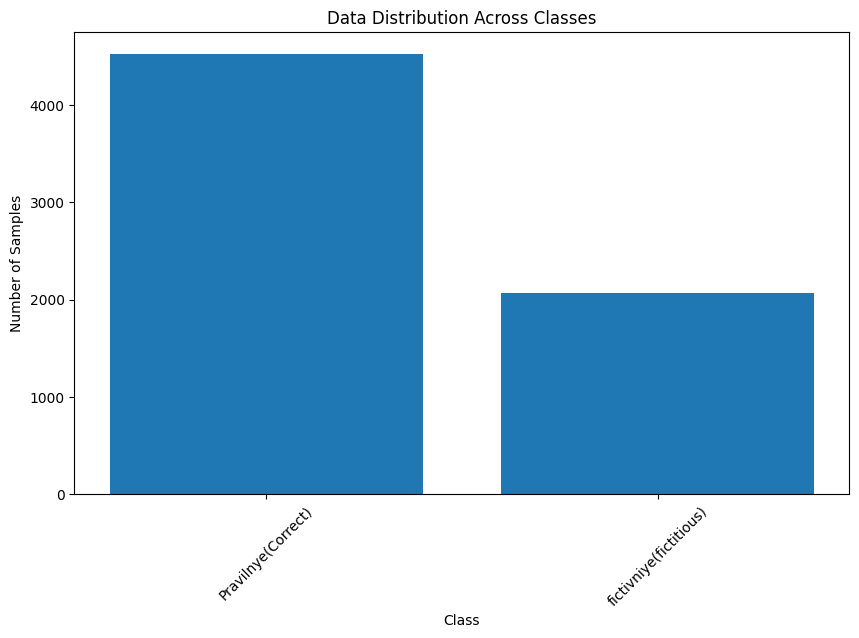

In [10]:
import os
import matplotlib.pyplot as plt

# Define a function to visualize data distribution
def visualize_data_distribution(image_paths, labels):
    # Initialize lists to store class names and corresponding sample counts
    class_names = []
    class_sample_counts = []

    # Iterate through unique labels (classes)
    unique_labels = set(labels)
    for label in unique_labels:
        # Count the number of samples for each class
        count = labels.count(label)
        class_name = 'fictivniye(fictitious)' if label == 1 else 'Pravilnye(Correct)'  # Replace 'Other' with the correct class name
        class_names.append(class_name)
        class_sample_counts.append(count)

    # Create a bar chart to visualize the data distribution
    plt.figure(figsize=(10, 6))
    plt.bar(class_names, class_sample_counts)
    plt.xlabel('Class')
    plt.ylabel('Number of Samples')
    plt.title('Data Distribution Across Classes')
    plt.xticks(rotation=45)  # Rotate class names for better readability

    # Show the plot
    plt.show()

# Example usage:

data_dir = '/kaggle/working/techosmotr/techosmotr/train' # Replace with the actual data directory
image_paths = []
labels = []

for class_name in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, class_name)
    for subfolder_name in os.listdir(class_dir):
        subfolder_path = os.path.join(class_dir, subfolder_name)
        for image_filename in os.listdir(subfolder_path):
            label = 1 if class_name == 'fictivniye(fictitious)' else 0
            image_path = os.path.join(subfolder_path, image_filename)
            image_paths.append(image_path)
            labels.append(label)

visualize_data_distribution(image_paths, labels)



## Now, let's visualize data distribution among fabricated class

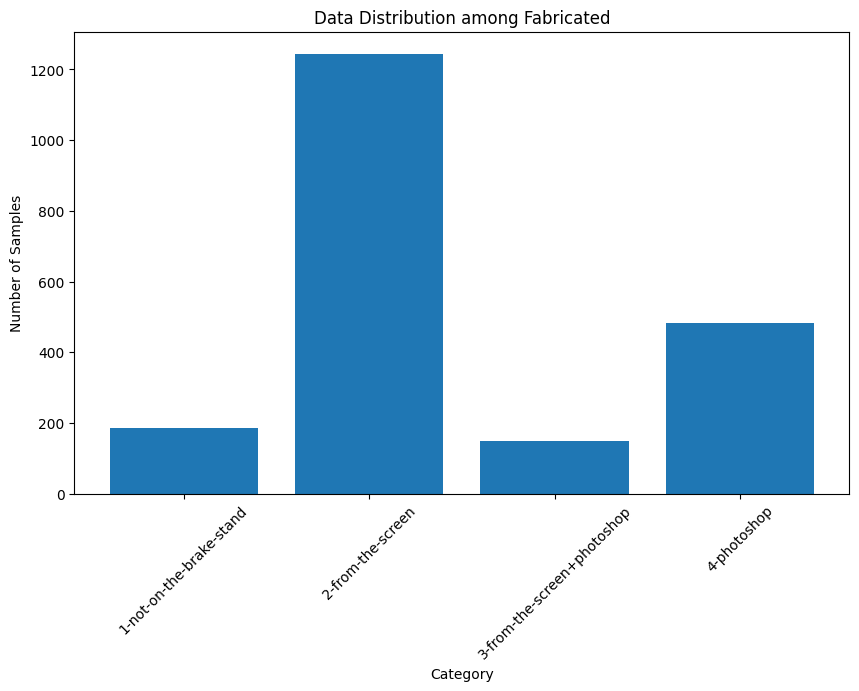

In [24]:
import os
import matplotlib.pyplot as plt

data_dir = '/kaggle/working/techosmotr/techosmotr/train/fictivniye(fictitious)'  # Replace with your data directory

# Initialize lists to store folder names and corresponding sample counts
folder_names = [
    '1-not-on-the-brake-stand',
    '2-from-the-screen',
    '3-from-the-screen+photoshop',
    '4-photoshop'  # Replace with an appropriate name for the "else" condition
]
folder_sample_counts = [0, 0, 0, 0]

# Iterate through the data directory to count the samples in each folder
for class_name in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, class_name)
    
    for image_filename in os.listdir(class_dir):
        if class_name == '1-not-on-the-brake-stand':
            label = 0
        elif class_name == '2-from-the-screen':
            label = 1
        elif class_name == '3-from-the-screen+photoshop':
            label = 2
        else:
            label = 3  # Assign a label for other folders

        folder_sample_counts[label] += 1

# Create a bar chart to visualize the data distribution among the folders
plt.figure(figsize=(10, 6))
plt.bar(folder_names, folder_sample_counts)
plt.xlabel('Category')
plt.ylabel('Number of Samples')
plt.title('Data Distribution among Fabricated')
plt.xticks(rotation=45)
plt.show()


## We can balance the data between 2 classes by providing data augmentation on the 'fabricated' class

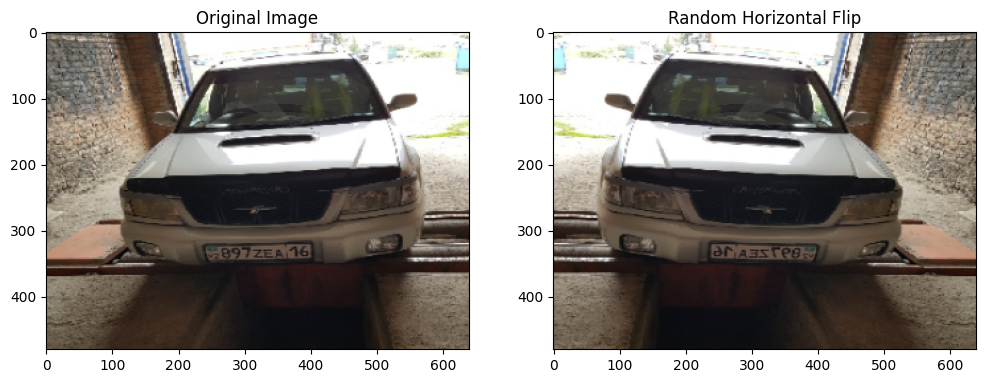

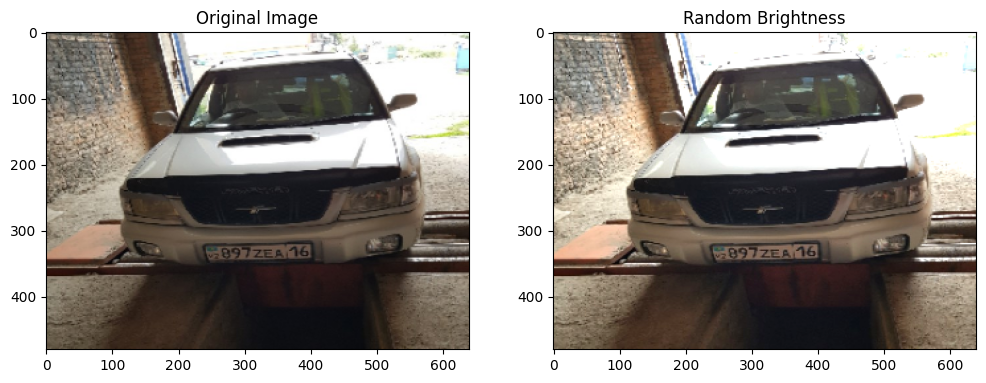

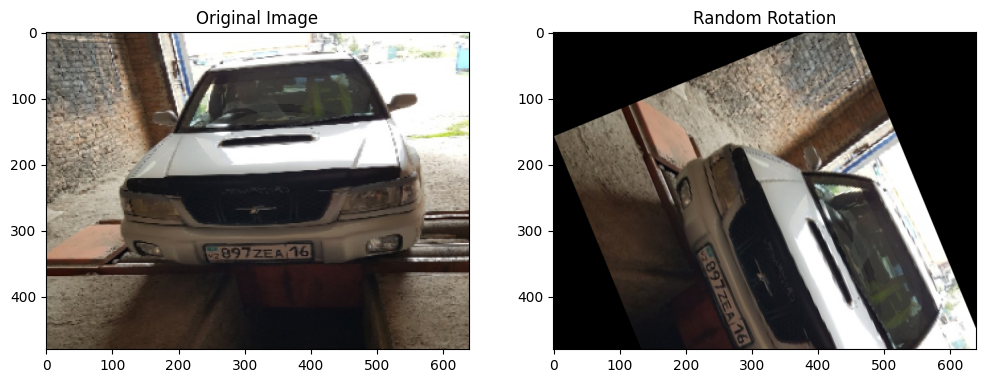

In [15]:
import cv2
import matplotlib.pyplot as plt
from random import random

# Load an example image


image_path = '/kaggle/working/techosmotr/techosmotr/train/pravilniye(correct)/0-correct/79892216.jpeg'
original_image = cv2.imread(image_path)  # Load the image

# Create a function to apply data augmentation and display images
def visualize_augmentation(image, augmentation_function, augmentation_name):
    augmented_image = augmentation_function(image)
    
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    
    plt.subplot(1, 2, 2)
    plt.title(augmentation_name)
    plt.imshow(cv2.cvtColor(augmented_image, cv2.COLOR_BGR2RGB))
    plt.show()

# Define example augmentation functions
def random_flip(image):
    if random() < 0.5:
        return cv2.flip(image, 1)  # Horizontal flip
    else:
        return image

def random_brightness(image):
    alpha = 1.0 + (random() - 0.5)  # Random brightness factor between 0.5 and 1.5
    return cv2.convertScaleAbs(image, alpha=alpha, beta=0)

def random_rotation(image):
    angle = random() * 360.0  # Random rotation angle
    image_center = tuple(map(lambda x: x / 2, image.shape[:2]))
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    return cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)

# Visualize the effects of different augmentations
visualize_augmentation(original_image, random_flip, "Random Horizontal Flip")
visualize_augmentation(original_image, random_brightness, "Random Brightness")
visualize_augmentation(original_image, random_rotation, "Random Rotation")


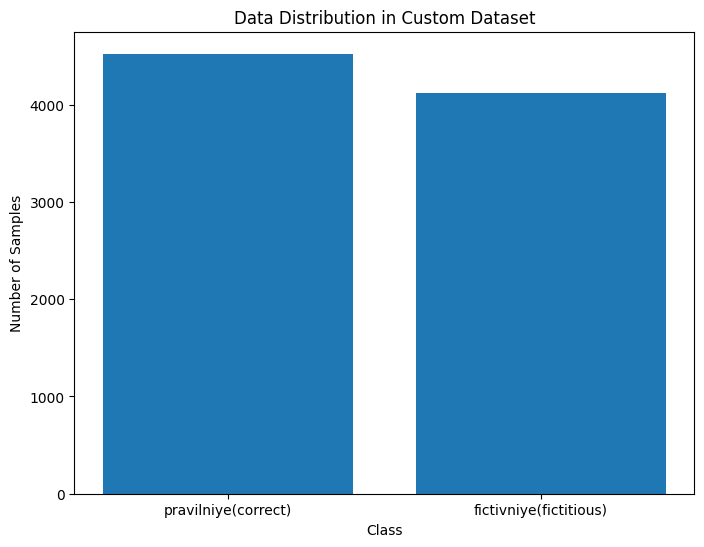

In [18]:
import os
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import KFold
from torch.utils.data import Dataset

from PIL import Image

if __name__=='__main__':
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    # Define the path to your data directory
    # Define the common image size and batch size
    target_size = (224, 224)  # Adjust the size as needed
    batch_size = 32
    num_classes = 2  # Number of classes (fictitious and correct)
    
    # Define a custom dataset for PyTorch
    class CustomImageDataset(Dataset):
        def __init__(self, data_dir, transform=None, oversample_class_1=True, oversampling_factor=2):
            self.data_dir = data_dir
            self.transform = transform
            self.image_paths = []
            self.labels = []

            for class_name in os.listdir(data_dir):
                class_dir = os.path.join(data_dir, class_name)
                for subfolder_name in os.listdir(class_dir):
                    subfolder_path = os.path.join(class_dir, subfolder_name)
                    for image_filename in os.listdir(subfolder_path):
                        label = 1 if class_name == 'fictivniye(fictitious)' else 0
                        image_path = os.path.join(subfolder_path, image_filename)
                        self.image_paths.append(image_path)
                        self.labels.append(label)

            if oversample_class_1:
                # Oversample class 1 (fictitious) by replicating its data
                self.image_paths.extend([path for path, label in zip(self.image_paths, self.labels) if label == 1] * (oversampling_factor - 1))
                self.labels.extend([label for label in self.labels if label == 1] * (oversampling_factor - 1))

        def __len__(self):
            return len(self.image_paths)

        def __getitem__(self, idx):
            image_path = self.image_paths[idx]
            image = Image.open(image_path)

            if self.transform:
                image = self.transform(image)

            label = self.labels[idx]
            return image, label

    # Data preprocessing and augmentation for PyTorch
    
    data_dir = '/kaggle/working/techosmotr/techosmotr/train'
    oversample_class_1 = True  # Set to True to oversample class 1
    oversampling_factor = 2  # Adjust the factor as needed
    
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),  # Randomly flip horizontally
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Color jitter
        transforms.RandomRotation(30),  # Randomly rotate up to 30 degrees
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Create an instance of the CustomImageDataset
    custom_dataset = CustomImageDataset(data_dir, transform=transform, oversample_class_1=oversample_class_1, oversampling_factor=oversampling_factor)

    import matplotlib.pyplot as plt

    # Initialize lists to store class names and corresponding sample counts
    class_names = ["pravilniye(correct)", "fictivniye(fictitious)"]  # Replace with the correct class names
    class_sample_counts = [0, 0]

    # Iterate through the custom dataset to count the samples
    for image, label in custom_dataset:
        class_sample_counts[label] += 1

    # Create a bar chart to visualize the data distribution
    plt.figure(figsize=(8, 6))
    plt.bar(class_names, class_sample_counts)
    plt.xlabel('Class')
    plt.ylabel('Number of Samples')
    plt.title('Data Distribution in Custom Dataset')
    plt.show()


    # After training on all folds, you can save the model or use it for predictions.

## Now, we can see that our data is relatively balanced

## Let's train our model now.
* We do 5-fold cross-validation to ensure generalazability of our model among different test sets
* We will save the model with best val_accuracy
* We train for 7 epochs each folding
* As the training model, I use ResNet-50 pre-trained on the ImageNet data

In [ ]:
# Initialize K-Fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
model = torchvision.models.resnet50(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, num_classes)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    # Track the best validation accuracy and save the corresponding model
best_val_accuracy = 0.0
best_model_path = 'best_model.pth'

    # Iterate through the folds
for fold, (train_indices, val_indices) in enumerate(kf.split(custom_dataset)):
        print(f"Training on Fold {fold + 1}...")

        # Create data loaders for training and validation
        train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
        val_sampler = torch.utils.data.SubsetRandomSampler(val_indices)

        train_loader = DataLoader(custom_dataset, batch_size=batch_size, sampler=train_sampler)
        val_loader = DataLoader(custom_dataset, batch_size=batch_size, sampler=val_sampler)

        # Load a pre-trained SOTA model (e.g., ResNet50)

        # Define loss and optimizer

        # Train the model
        model.train()
        for epoch in range(7):
            running_loss = 0.0
            for data in train_loader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
            print(f"Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}")

        # Evaluate the model on the validation set
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data in val_loader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        print(f"Validation accuracy for Fold {fold + 1}: {accuracy:.2f}%")
        if accuracy > best_val_accuracy:
            best_val_accuracy = accuracy
            torch.save(model.state_dict(), best_model_path)


# Now, let's load our model and provide inference for official test set.

In [ ]:
import os
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd

# Define the path to your test data directory
test_data_dir = '/kaggle/working/techosmotr/techosmotr/test'
test_csv_path = '/kaggle/working/test.csv'  # Path to your test CSV file
submission_csv_path = 'submission.csv'  # Path to save the submission file

# Define a custom dataset for test images
class TestImageDataset(Dataset):
    def __init__(self, data_dir, csv_path, transform=None):
        self.data_dir = data_dir
        self.csv_path = csv_path
        self.transform = transform
        self.file_indices = pd.read_csv(csv_path)['file_index'].tolist()

    def __len__(self):
        return len(self.file_indices)

    def __getitem__(self, idx):
        file_index = self.file_indices[idx]
        image_path = os.path.join(self.data_dir, f'{file_index}.jpeg')
        image = Image.open(image_path)

        if self.transform:
            image = self.transform(image)

        return image, file_index

# Data preprocessing and augmentation for test images (similar to training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create the custom dataset for test images
test_dataset = TestImageDataset(test_data_dir, test_csv_path, transform=transform)

# Create a data loader for the test dataset
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Load the trained model
model = torchvision.models.resnet50(pretrained=False)  # Create the same model architecture
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)  # Change the output layer to match your binary classification problem
model.load_state_dict(torch.load('best_model.pth'))  # Load the best model

# Move the model to the GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()  # Set the model to evaluation mode

# Make predictions on test images and create the submission file
file_indices = []
predicted_classes = []

with torch.no_grad():
    for images, indices in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        file_indices.extend(indices)
        predicted_classes.extend(predicted.tolist())
        
# Convert the tensor to a string and remove unwanted characters
file_indices = [str(index.item()) for index in file_indices]


# Create a DataFrame for the submission
submission_df = pd.DataFrame({'file_index': file_indices, 'class': predicted_classes})
# Save the submission DataFrame to a CSV file
submission_df.to_csv(submission_csv_path, index=False)

## We get the following submission file

In [131]:
submission_df

,file_index,class
0,76395310,0
1,78235074,0
2,74477562,0
3,70540972,0
4,73988993,0
...,...,...
772,73412262,1
773,74208388,1
774,77369587,0
775,77880820,1


## That's it, thank you for your attention.

## Below, I show some experiements I have done. 
## Here, I provide 5-fold cross validation to analyze accuracy pattern, but keep the trained models for next folds (just to analyze pattern). Performs not worse (obviously).

In [9]:
import os
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import KFold
from torch.utils.data import Dataset

from PIL import Image

if __name__=='__main__':
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    data_dir = '/kaggle/working/techosmotr/techosmotr/train'


    # Define the path to your data directory
    # Define the common image size and batch size
    target_size = (224, 224)  # Adjust the size as needed
    batch_size = 32
    num_classes = 2  # Number of classes (fictitious and correct)
    
    # Define a custom dataset for PyTorch
    class CustomImageDataset(Dataset):
        def __init__(self, data_dir, transform=None, oversample_class_1=False, oversampling_factor=2):
            self.data_dir = data_dir
            self.transform = transform
            self.image_paths = []
            self.labels = []

            for class_name in os.listdir(data_dir):
                class_dir = os.path.join(data_dir, class_name)
                for subfolder_name in os.listdir(class_dir):
                    subfolder_path = os.path.join(class_dir, subfolder_name)
                    for image_filename in os.listdir(subfolder_path):
                        label = 1 if class_name == 'fictivniye(fictitious)' else 0
                        image_path = os.path.join(subfolder_path, image_filename)
                        self.image_paths.append(image_path)
                        self.labels.append(label)

            if oversample_class_1:
                # Oversample class 1 (fictitious) by replicating its data
                self.image_paths.extend([path for path, label in zip(self.image_paths, self.labels) if label == 1] * (oversampling_factor - 1))
                self.labels.extend([label for label in self.labels if label == 1] * (oversampling_factor - 1))

        def __len__(self):
            return len(self.image_paths)

        def __getitem__(self, idx):
            image_path = self.image_paths[idx]
            image = Image.open(image_path)

            if self.transform:
                image = self.transform(image)

            label = self.labels[idx]
            return image, label

    # Data preprocessing and augmentation for PyTorch
    data_dir = '/kaggle/working/techosmotr/techosmotr/train'
#     oversample_class_1 = True  # Set to True to oversample class 1
#     oversampling_factor = 2  # Adjust the factor as needed
    
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),  # Randomly flip horizontally
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Color jitter
        transforms.RandomRotation(30),  # Randomly rotate up to 30 degrees
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Create an instance of the CustomImageDataset
    custom_dataset = CustomImageDataset(data_dir, transform=transform, oversample_class_1=oversample_class_1, oversampling_factor=oversampling_factor)

    # Initialize K-Fold cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    model = torchvision.models.resnet50(pretrained=True)
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, num_classes)
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    # Track the best validation accuracy and save the corresponding model
    best_val_accuracy = 0.0
    best_model_path = 'best_model.pth'

    # Iterate through the folds
    for fold, (train_indices, val_indices) in enumerate(kf.split(custom_dataset)):
        print(f"Training on Fold {fold + 1}...")

        # Create data loaders for training and validation
        train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
        val_sampler = torch.utils.data.SubsetRandomSampler(val_indices)

        train_loader = DataLoader(custom_dataset, batch_size=batch_size, sampler=train_sampler)
        val_loader = DataLoader(custom_dataset, batch_size=batch_size, sampler=val_sampler)

        # Load a pre-trained SOTA model (e.g., ResNet50)

        # Define loss and optimizer

        # Train the model
        model.train()
        for epoch in range(5):
            running_loss = 0.0
            for data in train_loader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
            print(f"Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}")

        # Evaluate the model on the validation set
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data in val_loader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        print(f"Validation accuracy for Fold {fold + 1}: {accuracy:.2f}%")



    # After training on all folds, you can save the model or use it for predictions.


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 258MB/s]


Training on Fold 1...
Epoch 1, Loss: 0.28986079951379157
Epoch 2, Loss: 0.14740673223433132
Epoch 3, Loss: 0.12056135974635589
Epoch 4, Loss: 0.09897143650405144
Epoch 5, Loss: 0.07707431186891851
Validation accuracy for Fold 1: 96.36%
Training on Fold 2...
Epoch 1, Loss: 0.08208384958722453
Epoch 2, Loss: 0.06778066506510609
Epoch 3, Loss: 0.0565149236962946
Epoch 4, Loss: 0.049871150200890405
Epoch 5, Loss: 0.04897412609079346
Validation accuracy for Fold 2: 98.27%
Training on Fold 3...
Epoch 1, Loss: 0.047837603346376
Epoch 2, Loss: 0.04301597102982966
Epoch 3, Loss: 0.03299849726203915
Epoch 4, Loss: 0.02545248737482543
Epoch 5, Loss: 0.020357139935273858
Validation accuracy for Fold 3: 99.19%
Training on Fold 4...
Epoch 1, Loss: 0.03174811795051853
Epoch 2, Loss: 0.03720414765530013
Epoch 3, Loss: 0.018277137322873865
Epoch 4, Loss: 0.019956755505505658
Epoch 5, Loss: 0.02512157416094013
Validation accuracy for Fold 4: 99.60%
Training on Fold 5...
Epoch 1, Loss: 0.0257650202673737

In [10]:
best_model_path = 'last_model.pth'

torch.save(model.state_dict(), best_model_path)

In [11]:
import os
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd

# Define the path to your test data directory
test_data_dir = '/kaggle/working/techosmotr/techosmotr/test'
test_csv_path = '/kaggle/working/test.csv'  # Path to your test CSV file
submission_csv_path = 'submission_weighted_aug.csv'  # Path to save the submission file

# Define a custom dataset for test images
class TestImageDataset(Dataset):
    def __init__(self, data_dir, csv_path, transform=None):
        self.data_dir = data_dir
        self.csv_path = csv_path
        self.transform = transform
        self.file_indices = pd.read_csv(csv_path)['file_index'].tolist()

    def __len__(self):
        return len(self.file_indices)

    def __getitem__(self, idx):
        file_index = self.file_indices[idx]
        image_path = os.path.join(self.data_dir, f'{file_index}.jpeg')
        image = Image.open(image_path)

        if self.transform:
            image = self.transform(image)

        return image, file_index

# Data preprocessing and augmentation for test images (similar to training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create the custom dataset for test images
test_dataset = TestImageDataset(test_data_dir, test_csv_path, transform=transform)

# Create a data loader for the test dataset
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Load the trained model
model = torchvision.models.resnet50(pretrained=False)  # Create the same model architecture
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)  # Change the output layer to match your binary classification problem
model.load_state_dict(torch.load('last_model_weighted_aug.pth'))  # Load the best model

# Move the model to the GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()  # Set the model to evaluation mode

# Make predictions on test images and create the submission file
file_indices = []
predicted_classes = []

with torch.no_grad():
    for images, indices in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        file_indices.extend(indices)
        predicted_classes.extend(predicted.tolist())
        
# Convert the tensor to a string and remove unwanted characters
file_indices = [str(index.item()) for index in file_indices]


# Create a DataFrame for the submission
submission_df = pd.DataFrame({'file_index': file_indices, 'class': predicted_classes})
# Save the submission DataFrame to a CSV file
submission_df.to_csv(submission_csv_path, index=False)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


## Below, using 5-fold, I train model to classify the category of the fabricated data. Averagely, I obtain accuracy of 86%. Though, the dataset is not balanced, and as mentioned, the labels are not always correct, so I would call that not so reliable accuracy, but still. 

In [19]:
import os
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import KFold
from torch.utils.data import Dataset

from PIL import Image

if __name__=='__main__':
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    # Define the path to your data directory
    # Define the common image size and batch size
    target_size = (224, 224)  # Adjust the size as needed
    batch_size = 32
    num_classes = 4  # Number of classes (fictitious and correct)
    
    # Define a custom dataset for PyTorch
    class CustomImageDataset(Dataset):
        def __init__(self, data_dir, transform=None, oversample_class_1=False, oversampling_factor=2):
            self.data_dir = data_dir
            self.transform = transform
            self.image_paths = []
            self.labels = []

            for class_name in os.listdir(data_dir):
                class_dir = os.path.join(data_dir, class_name)
                for image_filename in os.listdir(class_dir):
                    if class_name == '1-not-on-the-brake-stand':
                        label = 0
                    elif class_name == '2-from-the-screen':
                        label = 1
                    elif class_name == '3-from-the-screen+photoshop':
                        label = 2
                    else: 
                        label = 3
                    image_path = os.path.join(class_dir, image_filename)
                    self.image_paths.append(image_path)
                    self.labels.append(label)

            if oversample_class_1:
                # Oversample class 1 (fictitious) by replicating its data
                self.image_paths.extend([path for path, label in zip(self.image_paths, self.labels) if label == 1] * (oversampling_factor - 1))
                self.labels.extend([label for label in self.labels if label == 1] * (oversampling_factor - 1))

        def __len__(self):
            return len(self.image_paths)

        def __getitem__(self, idx):
            image_path = self.image_paths[idx]
            image = Image.open(image_path)

            if self.transform:
                image = self.transform(image)

            label = self.labels[idx]
            return image, label

    # Data preprocessing and augmentation for PyTorch
    data_dir = '/kaggle/working/techosmotr/techosmotr/train/fictivniye(fictitious)'
#     oversample_class_1 = True  # Set to True to oversample class 1
#     oversampling_factor = 2  # Adjust the factor as needed
    
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),  # Randomly flip horizontally
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Color jitter
        transforms.RandomRotation(30),  # Randomly rotate up to 30 degrees
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Create an instance of the CustomImageDataset
    custom_dataset = CustomImageDataset(data_dir, transform=transform, oversampling_factor=oversampling_factor)

    # Initialize K-Fold cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

        # Track the best validation accuracy and save the corresponding model
    best_val_accuracy = 0.0
    best_model_path = 'best_model_4class.pth'
    # Iterate through the folds
    for fold, (train_indices, val_indices) in enumerate(kf.split(custom_dataset)):
        print(f"Training on Fold {fold + 1}...")
        model = torchvision.models.resnet50(pretrained=True)
        num_features = model.fc.in_features
        model.fc = nn.Linear(num_features, num_classes)
        model = model.to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


        # Create data loaders for training and validation
        train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
        val_sampler = torch.utils.data.SubsetRandomSampler(val_indices)

        train_loader = DataLoader(custom_dataset, batch_size=batch_size, sampler=train_sampler)
        val_loader = DataLoader(custom_dataset, batch_size=batch_size, sampler=val_sampler)

        # Load a pre-trained SOTA model (e.g., ResNet50)

        # Define loss and optimizer

        # Train the model
        model.train()
        for epoch in range(20):
            running_loss = 0.0
            for data in train_loader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
            print(f"Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}")

        # Evaluate the model on the validation set
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data in val_loader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        print(f"Validation accuracy for Fold {fold + 1}: {accuracy:.2f}%")
        if accuracy > best_val_accuracy:
            best_val_accuracy = accuracy
            torch.save(model.state_dict(), best_model_path)


Training on Fold 1...
Epoch 1, Loss: 0.9111403582187799
Epoch 2, Loss: 0.6431805732158514
Epoch 3, Loss: 0.5378754643293527
Epoch 4, Loss: 0.4656281992793083
Epoch 5, Loss: 0.39507790482961214
Epoch 6, Loss: 0.35000405517908245
Epoch 7, Loss: 0.28374927319013155
Epoch 8, Loss: 0.2529656376976233
Epoch 9, Loss: 0.21988343232526228
Epoch 10, Loss: 0.18284537850950772
Epoch 11, Loss: 0.1531384580840285
Epoch 12, Loss: 0.1247876279700834
Epoch 13, Loss: 0.09836096975665826
Epoch 14, Loss: 0.09313211958998671
Epoch 15, Loss: 0.07600071282985692
Epoch 16, Loss: 0.06486385415952939
Epoch 17, Loss: 0.06472550339710254
Epoch 18, Loss: 0.050723094439420566
Epoch 19, Loss: 0.05839373499083404
Epoch 20, Loss: 0.04943286769020443
Validation accuracy for Fold 1: 85.47%
Training on Fold 2...
Epoch 1, Loss: 0.9046617247737371
Epoch 2, Loss: 0.6429075042788799
Epoch 3, Loss: 0.5327972351358488
Epoch 4, Loss: 0.4705863454594062
Epoch 5, Loss: 0.3923580273985863
Epoch 6, Loss: 0.3204317476886969
Epoch 7,

## Next, I tried to get some saliency map, to show which regions of the image influenced our model to show (rightly) that it is a wrong image.

tensor([0])


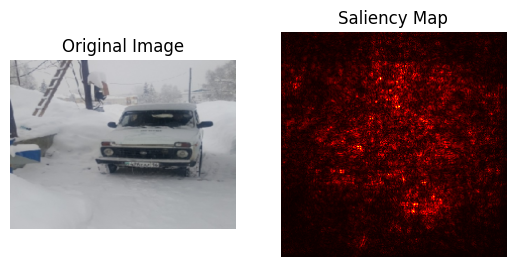

In [140]:
import cv2
import torch
from torch.autograd import Variable
from torch.nn import functional as F
import numpy as np
import matplotlib.pyplot as plt

# Load the test image you want to create a heatmap for
image_path = '/kaggle/working/techosmotr/techosmotr/train/fictivniye(fictitious)/1-not-on-the-brake-stand/70946986.jpeg'  # Replace with the path to your test image
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image

# Load a pre-trained ResNet-50 model
# model = models.resnet50(pretrained=True)
model.eval()

# Load an image for which you want to create the saliency map
img_path = image_path
img = Image.open(img_path)

# Define a preprocessing transform
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

img_tensor = preprocess(img)
img_tensor = img_tensor.unsqueeze(0)  # Add batch dimension

# Forward pass to get the predicted class scores
with torch.enable_grad():
    img_variable = torch.autograd.Variable(img_tensor, requires_grad=True)
    output = model(img_variable)
    _, target_class = output.max(1)
    print(target_class)
    output[0, target_class].backward()

# Calculate the gradients
saliency_map = img_variable.grad.data
saliency_map = saliency_map.abs().max(dim=1)[0]

# Normalize the saliency map
saliency_map = (saliency_map - saliency_map.min()) / (saliency_map.max() - saliency_map.min())

# Convert to numpy array
saliency_map = saliency_map.numpy()[0]

# Display the original image and the saliency map side by side
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(saliency_map, cmap='hot')
plt.title('Saliency Map')
plt.axis('off')

plt.show()


## Right now, dont know how to interpret it, so I have a room for improvement.